# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start on moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   17th of April 2023

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong

# Main program start:

Read in the data, and make arrays of each variable (and understand these!).

In [4]:
# Get data (with this very useful NumPy reader):
data = np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True)    # For faster running
# data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

# Kinematics (energy and direction) of the jet:
energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']

# Classification variables (those used in Aleph's NN):
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']

# Aleph's NN score:
nnbjet = data['nnbjet']

# Truth variable whether it really was a b-jet or not (i.e. target)
isb    = data['isb']

# Inspect the data:
Define the histogram range and binning (important - programs are generally NOT good at this):

In [5]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

In [6]:
prob_b_bjets = prob_b[isb == 1]
prob_b_ljets = prob_b[isb == 0]
bqvjet_bjets = bqvjet[isb == 1]
bqvjet_ljets = bqvjet[isb == 0]
spheri_bjets = spheri[isb == 1]
spheri_ljets = spheri[isb == 0]
pt2rel_bjets = pt2rel[isb == 1]
pt2rel_ljets = pt2rel[isb == 0]
multip_bjets = multip[isb == 1]
multip_ljets = multip[isb == 0]
ptlrel_bjets = ptlrel[isb == 1]
ptlrel_ljets = ptlrel[isb == 0]

### Produce 1D figures:

/tmp/ipykernel_3167/2347249079.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


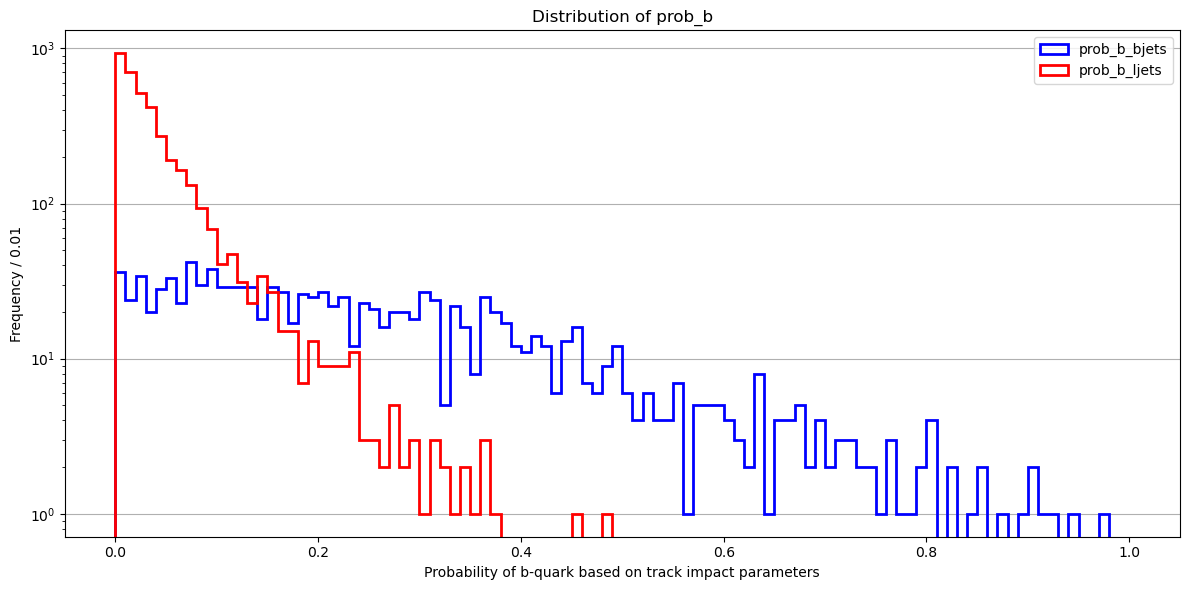

In [7]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

/tmp/ipykernel_3167/2347249079.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


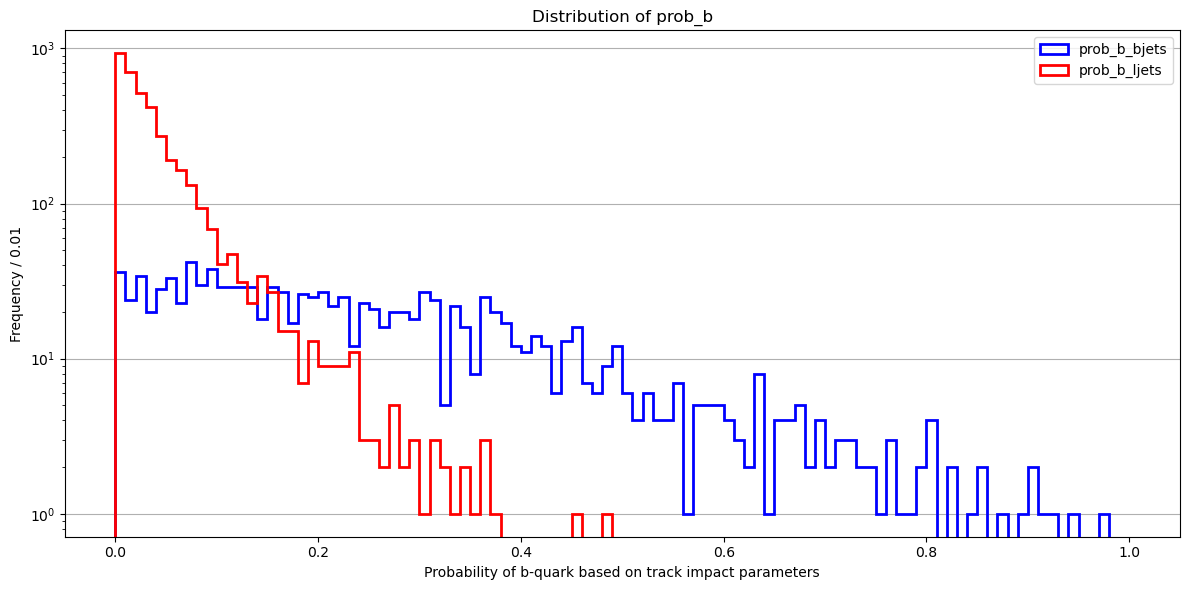

In [8]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

### Produce 2D figures:

/tmp/ipykernel_3167/2045483418.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_3167/2045483418.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


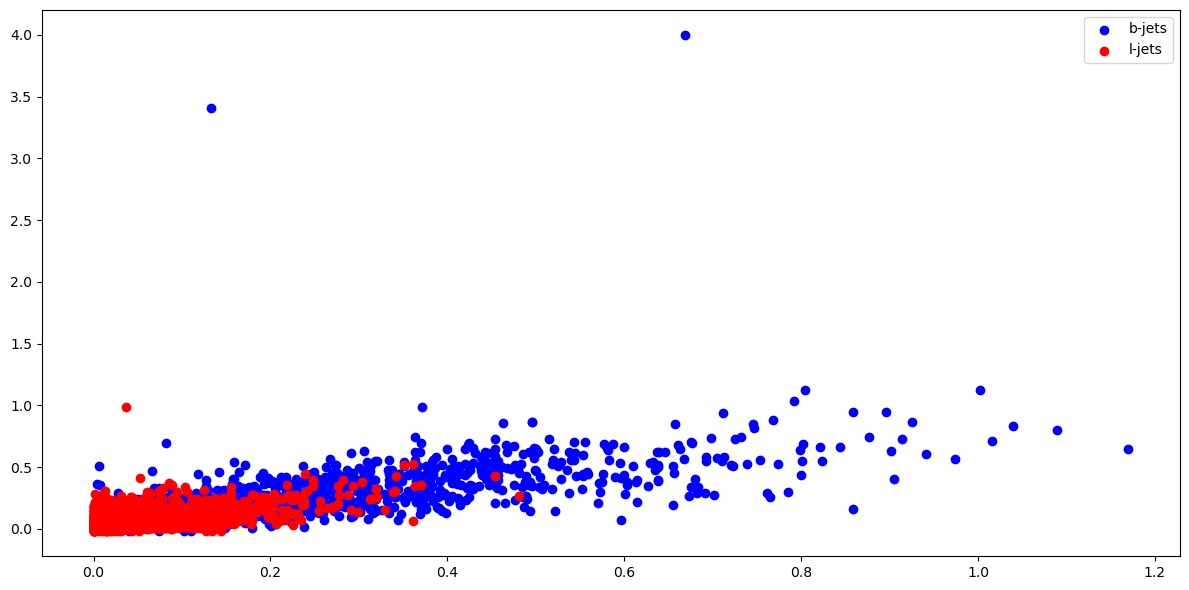

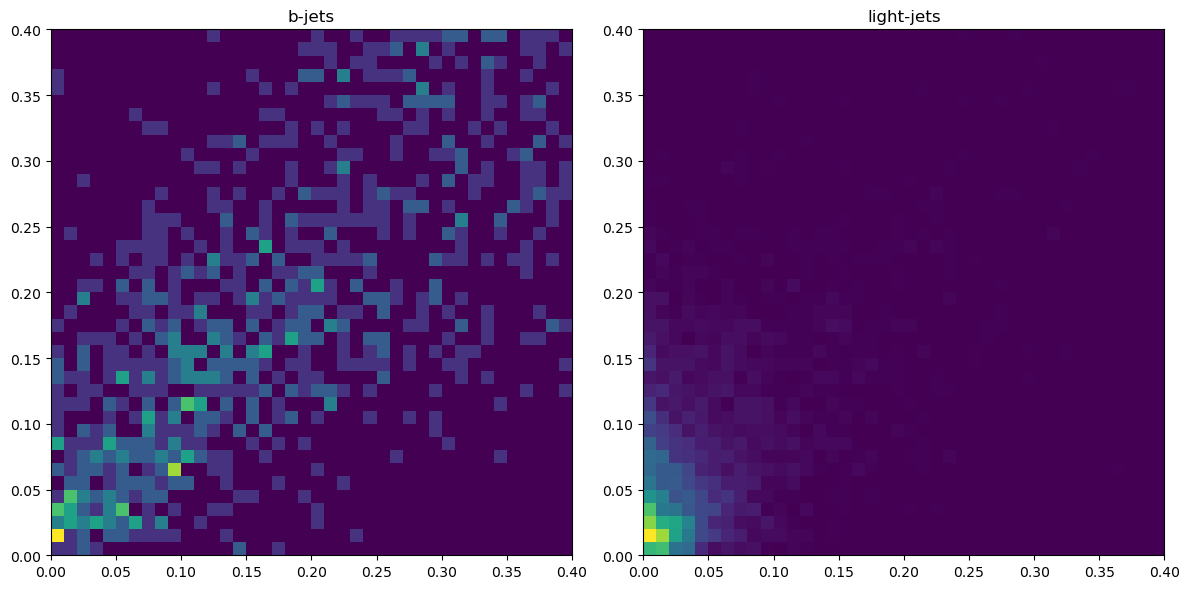

In [9]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()
fig2.show()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")

fig3.tight_layout()
fig3.show()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

# Selection:

In [10]:
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
# Note: This is where you change things (selection values and adding variables) to improve the performance:

# Think about how the above cuts "works", and then imagine what I have in mind below, trying to refine the selection:

cut_bqvjet = 0.34
cut_prob_b = 0.15
cut_spheri = 0.2 # Greater than
cut_pt2rel = 0.25 # Less than
cut_multip = 0.18
cut_ptlrel = 0.4

# loose_propb = 0.07
# tight_propb = 0.26
# loose_bqvjet = 0.09
# tight_bqvjet = 0.34


# If prob_b indicate b-quark, call it a b-quark, otherwise not!
bquark=[]
for i in np.arange(len(prob_b)):
    if (bqvjet[i] > cut_bqvjet):
        bquark.append(1)
    elif prob_b[i] > cut_prob_b:
        bquark.append(1)
   # elif spheri[i] > cut_spheri:
   #     bquark.append(1)
   # elif pt2rel[i] < cut_pt2rel:
   #     bquark.append(1)
    elif multip[i] > cut_multip:
        bquark.append(1)
   # elif ptlrel[i] > cut_ptlrel:
   #     bquark.append(1)       
    else:
        bquark.append(0)

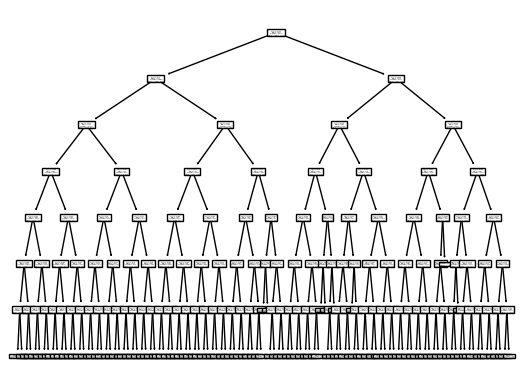

Accuracy of training set: 0.9062
Accuracy of test set: 0.8916


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
data = np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True)   # For more data
big_data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

# create dataset with two classes of objects in some 2D space
X = pd.DataFrame(data, columns = ['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'])
y = pd.DataFrame(data, columns = ["isb"])
big_X = pd.DataFrame(big_data, columns = ['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'])
big_y = pd.DataFrame(big_data, columns = ["isb"])

# create a decision tree with some depth of 'leafs'
tree_clf = DecisionTreeClassifier(max_depth=7)
tree_clf.fit(big_X, big_y)

plot_tree(tree_clf) # visualise tree
plt.rcParams['figure.figsize'] = [10, 6]
plt.show()

print(f"Accuracy of training set: {tree_clf.score(big_X, big_y)}")
print(f"Accuracy of test set: {tree_clf.score(X, y)}")


In [12]:
from sklearn import metrics
metrics.roc_curve(y, data["prob_b"])

(array([0.        , 0.        , 0.        , ..., 0.98691784, 0.98979592,
        1.        ]),
 array([0.00000000e+00, 8.48896435e-04, 5.51782683e-02, ...,
        9.94057725e-01, 9.94057725e-01, 1.00000000e+00]),
 array([2.1698e+00, 1.1698e+00, 6.3830e-01, ..., 2.0000e-04, 1.0000e-04,
        0.0000e+00]))

### Evaluate the selection:

In [13]:
N, accuracy, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


RESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  399
  False-Negative (0,1) =  13
  False-Positive (1,0) =  3423
  True-Positive (1,1)  =  1165
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.6872
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.31279999999999997


In [14]:
### Compare with Aleph NN-approach from 1990'ies:

In [15]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3700
  False-Negative (0,1) =  372
  False-Positive (1,0) =  122
  True-Positive (1,1)  =  806
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0988
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9012


# Suggested problems:

1. Start by plotting the six "Aleph classification variables" for signal and background, and see which seems to separate most. Possibly draw ROC curves for all of these separately, to quantify this.

2. As you can see, the Aleph-NN performs significantly better. Try to optimize your cuts, combining several of them in smart ways. You may also want to make a linear combination (i.e. Fisher Linear Discriminant) to do better. Challenge yourself to push it as far as you can (well, for say 30 minutes).

3. Does including more data (50000 instead of 5000 events) help your performance?

4. Currently, the scoring (also called the loss function) is simply done by considering the fraction of wrong estimates. Think about what the alternatives could be, especially if you were to give a continuous score like the Aleph-NN.

# Learning points:

From this exercise you should get a feel for the problem at hand, namely how to separate two populations in a 6-dimensional space. It is hard to imagine, yet with simple cuts you should be able to get "some performance", though never anywhere close to the Aleph-NN. You should learn, that it is hard, but that at least the fact that you have known cases makes you capable of getting that "some performance". And you should of course be able to draw ROC curves to compare performances.

The next steps (i.e. following exercises) are to improve this performance through the use of Machine Learning (ML), and make you capable not only of getting results, but also confident in optimising them, and certainly proficient in interpreting them.

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

2023-04-26 14:34:30.701276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [147]:
# set up the network hyperparameters
n_inputs = 6
n_hidden1 = 10
n_hidden2 = 10
n_outputs = 1
batch_norm_momentum = 0.9
learning_rate = 0.001
init = tf.keras.initializers.VarianceScaling(scale=1.0, mode='fan_in')
centropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# network structure
nn_reg = tf.keras.models.Sequential([
  Flatten(input_shape=(6, 1)),
  Dense(n_hidden1, activation='sigmoid', kernel_initializer=init),
  BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
  Dense(n_hidden2, activation='sigmoid', kernel_initializer=init),
  BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True),
  Dense(n_outputs, activation='sigmoid', kernel_initializer=init),
  BatchNormalization(momentum=batch_norm_momentum, center=True, scale=True)
])

nn_reg.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=SGD(learning_rate), metrics=['accuracy'])

/home/jufo/anaconda3/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [148]:
X_train = X.loc[:3999, :]
y_train = y.loc[:3999, :]
X_val = X.loc[4000:, :]
y_val = y.loc[4000:, :]


Epoch 1/50
20/20 [==============================] - 2s 47ms/step - loss: 3.2990 - accuracy: 0.6812 - val_loss: 0.6635 - val_accuracy: 0.7660
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 2.9550 - accuracy: 0.7007 - val_loss: 1.1778 - val_accuracy: 0.7900
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 2.7321 - accuracy: 0.7218 - val_loss: 1.9902 - val_accuracy: 0.7570
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 2.3584 - accuracy: 0.7385 - val_loss: 2.0180 - val_accuracy: 0.7680
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 1.9765 - accuracy: 0.7617 - val_loss: 1.8278 - val_accuracy: 0.7820
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 1.6814 - accuracy: 0.7825 - val_loss: 1.4504 - val_accuracy: 0.8010
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 1.4464 - accuracy: 0.7970 - val_loss: 1.1007 - val_accuracy: 0.8240
Epoch 8/50
20/20 [=

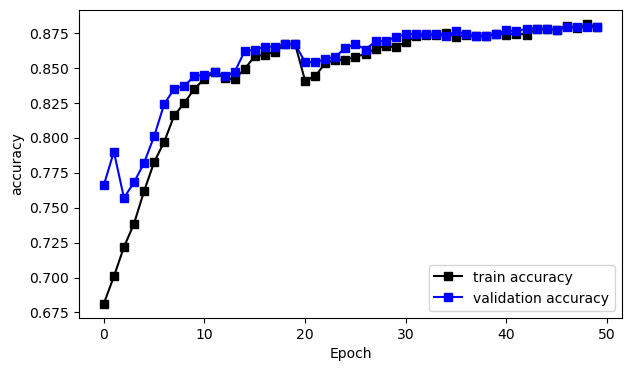

In [149]:
n_epochs = 50
batch_size = 200

history = nn_reg.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val))

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(np.arange(n_epochs), history.history['accuracy'], 'ks-', label='train accuracy')
ax.plot(np.arange(n_epochs), history.history['val_accuracy'], 'bs-', label='validation accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [150]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)